### Reconstruct an Upgrade event and conduct LLH scans using the LLH Service

In [1]:
import pickle
import math
import os
from multiprocessing import Process
from copy import deepcopy

from matplotlib import pyplot as plt
import numpy as np

from freedom.llh_service.llh_client import LLHClient
from freedom.reco import crs_reco

### Check for a consistent llh service / client installation

In [2]:
import zmq
from freedom.llh_service import llh_cython
assert zmq.zmq_version() == llh_cython.zmq_version(), "Inconsistent zmq installations!"

In [3]:
params = {'legend.fontsize': 17,
          'figure.figsize': (15, 9.3),
          'axes.labelsize': 24,
          'axes.titlesize': 24,
          'xtick.labelsize': 22,
          'ytick.labelsize': 22}
plt.rcParams.update(params)

In [4]:
cvmfs_path = '/cvmfs/icecube.opensciencegrid.org/users/peller/freeDOM/resources'
model_path = f'{cvmfs_path}/Upgrade_NNs'

In [5]:
event_ind = 16256

In [6]:
with open(f'{cvmfs_path}/test_events_upgrade.pkl', 'rb') as f:
    event = pickle.load(f)[event_ind]

### LLH service configuration:

In [7]:
base_conf = {
        "poll_timeout": 1,
        "flush_period": 1,
        "n_hypo_params": 8,
        "n_hit_features": 10,
        "n_evt_features": 2,
        "send_hwm": 10000,
        "recv_hwm": 10000,
        "batch_size": {"n_hypos": 500},
        "req_addr": "tcp://127.0.0.1:*",
        "ctrl_addr": "tcp://127.0.0.1:12350"
}

In [8]:
def start_upgrade_service(base_conf, index, obs_per_hypo, hitnet_file, chargenet_file, cuda_device=0):
    conf = deepcopy(base_conf)
    conf["batch_size"]["n_observations"] = conf["batch_size"]["n_hypos"] * obs_per_hypo
    conf["ctrl_addr"] = crs_reco.adjust_addr_string(conf["ctrl_addr"], index)
    conf["hitnet_file"] = hitnet_file
    conf["chargenet_file"] = chargenet_file
    proc = Process(target=crs_reco.start_service, 
                   args=(conf, conf["ctrl_addr"], conf["req_addr"], cuda_device))
    proc.start()
    
    return proc, conf["ctrl_addr"]

In [9]:
%%capture
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
dc_proc, dc_ctrl_addr = start_upgrade_service(base_conf, 0, 16, 
                                              f"{model_path}/hitNet_DOMs.hdf5", 
                                              f"{model_path}/chargeNet_DOMs.hdf5")
degg_proc, degg_ctrl_addr = start_upgrade_service(base_conf, 1, 32, 
                                                  f"{model_path}/hitNet_DEggs.hdf5", 
                                                  f"{model_path}/chargeNet_DEggs.hdf5")
mdom_proc, mdom_ctrl_addr = start_upgrade_service(base_conf, 2, 64, 
                                                  f"{model_path}/hitNet_mDOMs.hdf5", 
                                                  f"{model_path}/chargeNet_mDOMs.hdf5")

### Construct the clients, one per DOM type

In [10]:
%%time
dc_client = LLHClient(ctrl_addr=dc_ctrl_addr, conf_timeout=60000)
degg_client = LLHClient(ctrl_addr=degg_ctrl_addr, conf_timeout=60000)
mdom_client = LLHClient(ctrl_addr=mdom_ctrl_addr, conf_timeout=60000)

CPU times: user 5.1 ms, sys: 6.45 ms, total: 11.6 ms
Wall time: 23.5 s


### Reconstruct the event

In [11]:
rng = np.random.default_rng()

n_live_points = 97

event['hit_data'] = [event['hits_DOM'], event['hits_mDOM'], event['hits_DEgg']]
event['evt_data'] = [event['total_charge_DOM'], event['total_charge_mDOM'], event['total_charge_DEgg']]

In [12]:
%%time
fit_result = crs_reco.batch_crs_fit(event, [dc_client, mdom_client, degg_client], rng,
                                    n_live_points=97, do_postfit=True, store_all=True,
                                    spherical_indices=[[4, 5]], batch_size=12)
fit_result['n_calls']

CPU times: user 339 ms, sys: 47.3 ms, total: 386 ms
Wall time: 15.3 s


2935

### 1D scans

In [13]:
true_params = event['params']

par_names = ['x', 'y', 'z', 'time',
             'azimuth', 'zenith', 
             'cascade energy', 'track energy']

par_pairs = [(0, 1), (0, 2), (1, 2), (3, 2),
             (4, 5), (4, 2), (4, 0), (6, 7)
            ]

gridsize = 100
spacings = [np.linspace(true_params[0]-30, true_params[0]+30, 101),
            np.linspace(true_params[1]-30, true_params[1]+30, 101),
            np.linspace(true_params[2]-20, true_params[2]+20, 101),
            np.linspace(true_params[3]-80, true_params[3]+160, 101),
            np.linspace(0, 2*math.pi, 101),
            np.linspace(0, math.pi, 101),
            np.logspace(-1, 3, 101),
            np.logspace(-1, 3, 101)
           ]

In [14]:
def upgrade_llh(params):
    components = []
    for client, suffix in zip([dc_client, mdom_client, degg_client], ['DOM', 'mDOM', 'DEgg']):
        components.append(client.eval_llh(event[f'hits_{suffix}'], event[f'total_charge_{suffix}'], params))
    total = sum(components)
    
    return total, components

def scan_1d(par_ind, base_params):
    n_pts = len(spacings[par_ind])
    params = np.repeat(base_params[np.newaxis, :], n_pts, axis=0)
    params[:, par_ind] = spacings[par_ind]
    
    return upgrade_llh(params)

In [15]:
truth_llh = upgrade_llh(event['params'])[0]
print(f"-LLH at truth: {truth_llh:.3f}")
print(f"-LLH at best fit: {fit_result['fun']:.3f}")

-LLH at truth: -89.687
-LLH at best fit: -95.054


In [16]:
n_DOM = len(event['hits_DOM'])
n_DEgg = len(event['hits_DEgg'])
n_mDOM = len(event['hits_mDOM'])

In [17]:
def plot_1d_scans(base_params):
    lab = ['total', 'DOM (%i)'%(n_DOM), 'mDOM (%i)'%(n_mDOM), 'DEgg (%i)'%(n_DEgg)]
    fig, axes = plt.subplots(figsize=(35, 12), nrows=2, ncols=4)
    
    truth = event['params']
    best_fit = fit_result['x']

    for i, ax in enumerate(axes.flat):
        total, comps = scan_1d(i, base_params)
        for curve, label in zip([total] + comps, lab):
            ax.plot(spacings[i], curve - curve.min(), label=label, linewidth=3)

        if truth[i] != 0:
            ax.axvline(truth[i], color='black', linestyle='--', label='truth')
        
        ax.axvline(best_fit[i], color='red', label='best fit')

        if i == 3:
            ax.legend()

        if i > 5:
            ax.set_xscale('log')

        ax.set_ylabel(r'$\Delta$LLH')
        ax.set_xlabel(par_names[i])

Text(0.5, 0.95, 'scan around truth')

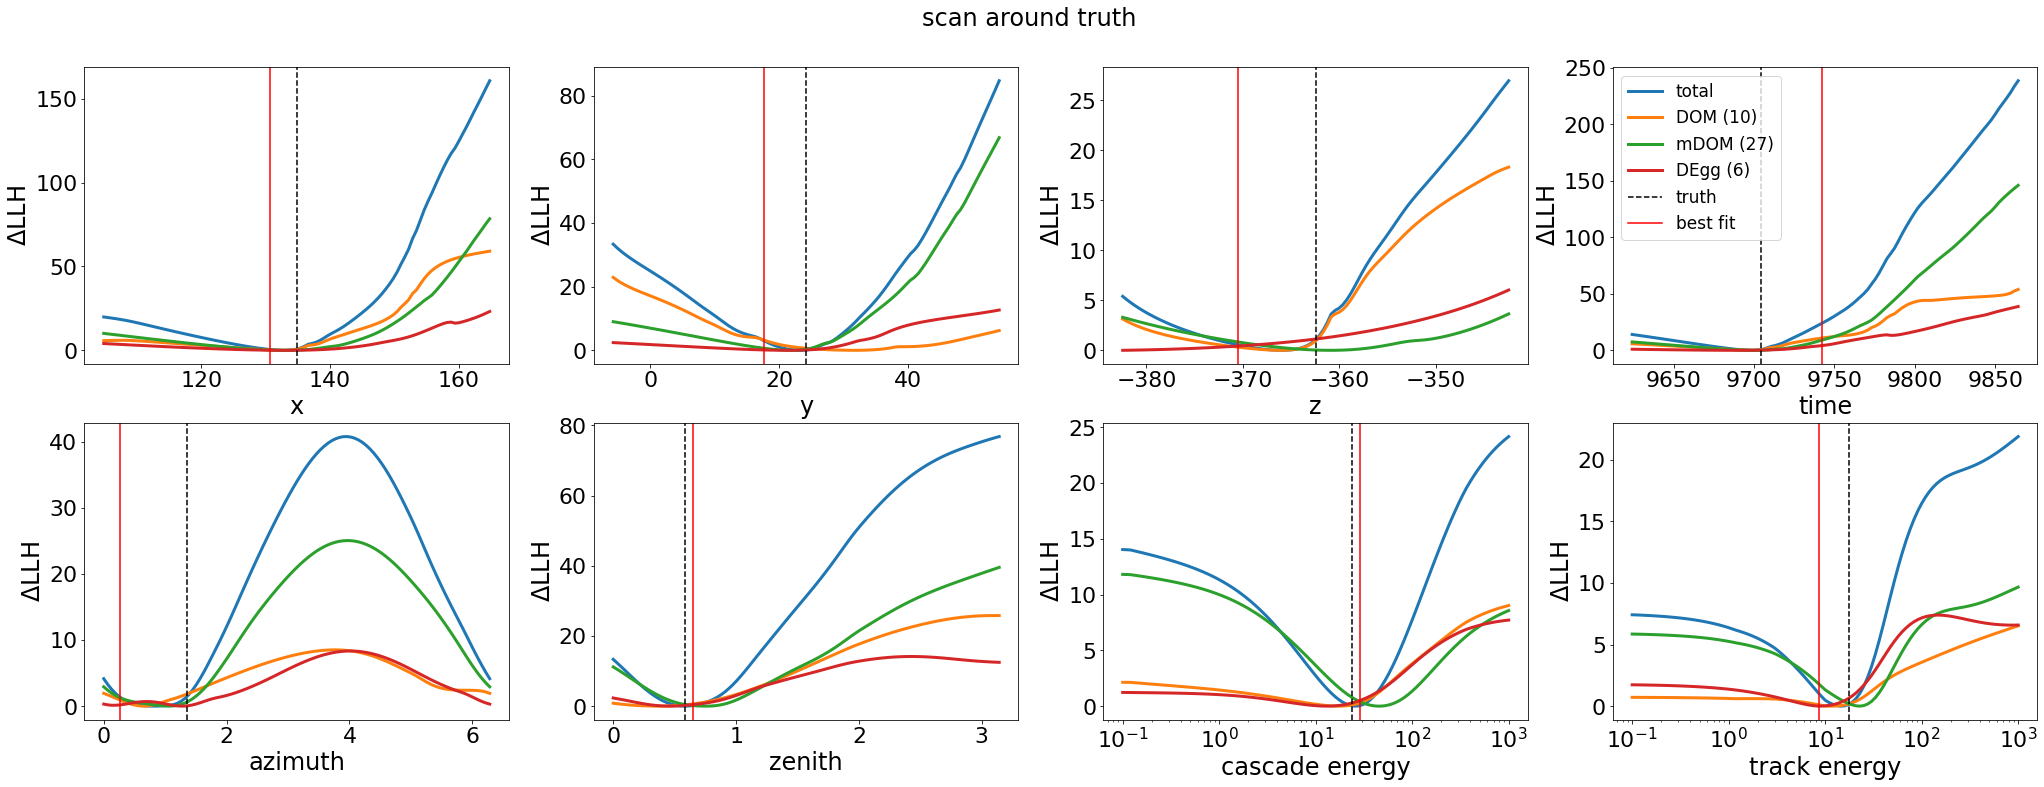

In [18]:
plot_1d_scans(event['params'])
plt.gcf().suptitle('scan around truth', y=0.95, fontsize=24)

Text(0.5, 0.95, 'scan around best fit')

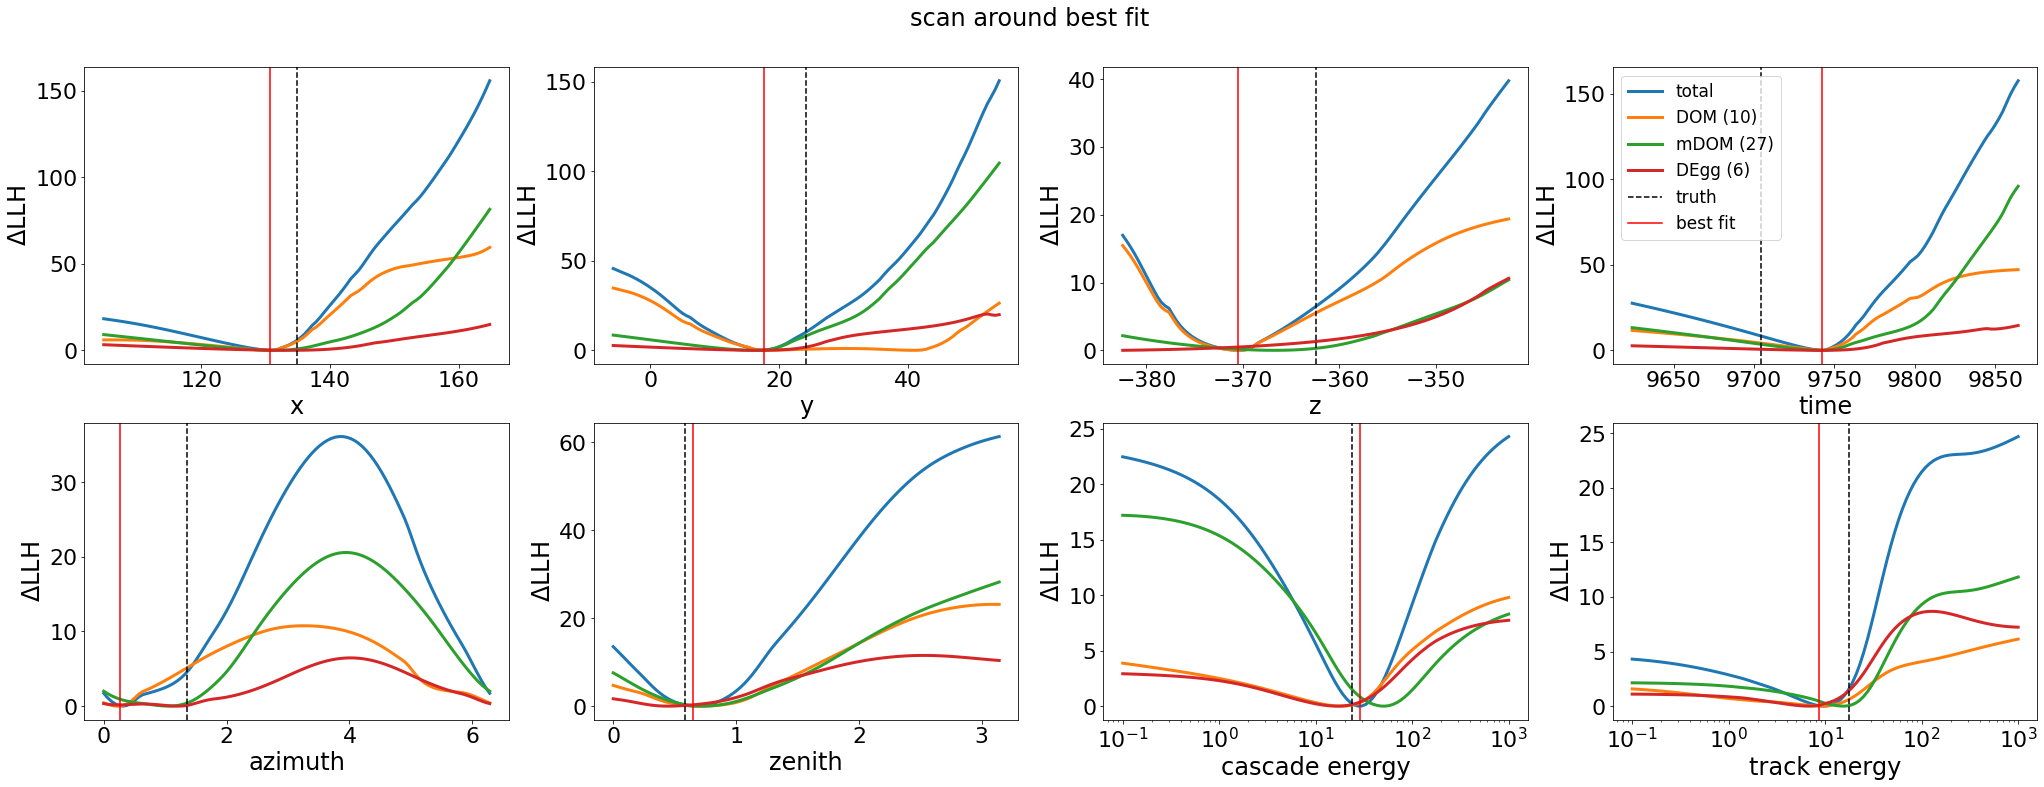

In [19]:
plot_1d_scans(fit_result["x"])
plt.gcf().suptitle('scan around best fit', y=0.95, fontsize=24)

### 2D scans

In [20]:
def colorbar(mappable):
    # from https://joseph-long.com/writing/colorbars/
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    cbar.ax.tick_params(labelsize=12)
    return cbar

# utility function to map out a 2d NLL slice
def map_2d(inds, steps, event, base_params=event['params']):
    mg = np.meshgrid(*steps)
    
    n_hypotheses = mg[0].size
    
    # param table is a table of hypotheses to evaluate
    # each row contains a value for each of the 8 hypothesis parameters
    param_table = np.repeat(base_params[np.newaxis, :], n_hypotheses, axis=0)

    # load hypotheses to evaluate into the param table
    for ind, coord in zip(inds, mg):
        param_table[:, ind] = coord.flat
        
    return upgrade_llh(param_table)[0].reshape([step.size for step in steps[::-1]])

def plot_2d(inds, steps, true_params, base_params, ax):
    llh_map = map_2d(inds, steps, event, base_params)

    delta = llh_map - llh_map.min()
    
    im = ax.pcolormesh(*steps, delta, cmap='Spectral',
                       rasterized=True, linewidth=0, shading='auto')    
    colorbar(im)
        
    # place crosshair at true parameters
    ax.axvline(true_params[0], label='truth')
    ax.axhline(true_params[1])
    
    # white star at best fit point
    best_fit = [fit_result["x"][i] for i in inds]
    ax.plot(*[[x] for x in best_fit], 'w*', markersize=10, label='best fit')

In [21]:
def plot_2d_scan(base_params):
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16,8))
    plt.subplots_adjust(wspace=0.5)
    plt.subplots_adjust(hspace=0.25)

    axiter = axes.flat
    for i, ax in enumerate(axiter):
        ind0, ind1 = par_pairs[i]
        grid_spacing = (spacings[ind0], spacings[ind1])
        plot_2d((ind0, ind1), grid_spacing, (true_params[ind0], true_params[ind1]), base_params, ax)
        ax.set_xlabel(par_names[ind0], fontsize=12)
        ax.set_ylabel(par_names[ind1], fontsize=12)
        ax.tick_params(labelsize=12)

        if par_names[ind0].endswith('energy'):
            ax.set_xscale('log')
        if par_names[ind1].endswith('energy'):
            ax.set_yscale('log')
            
        if i == 3:
            ax.legend()

CPU times: user 327 ms, sys: 29.4 ms, total: 356 ms
Wall time: 7.92 s


Text(0.5, 0.95, 'Scan around truth')

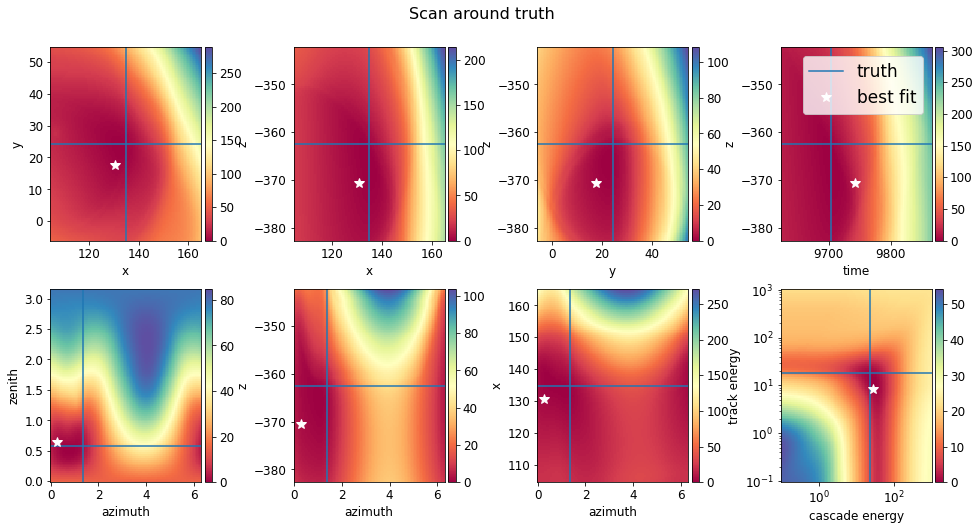

In [22]:
%%time
plot_2d_scan(event['params'])
plt.gcf().suptitle('Scan around truth', fontsize=16, y=0.95)

CPU times: user 322 ms, sys: 20.2 ms, total: 343 ms
Wall time: 7.92 s


Text(0.5, 0.95, 'Scan around best fit')

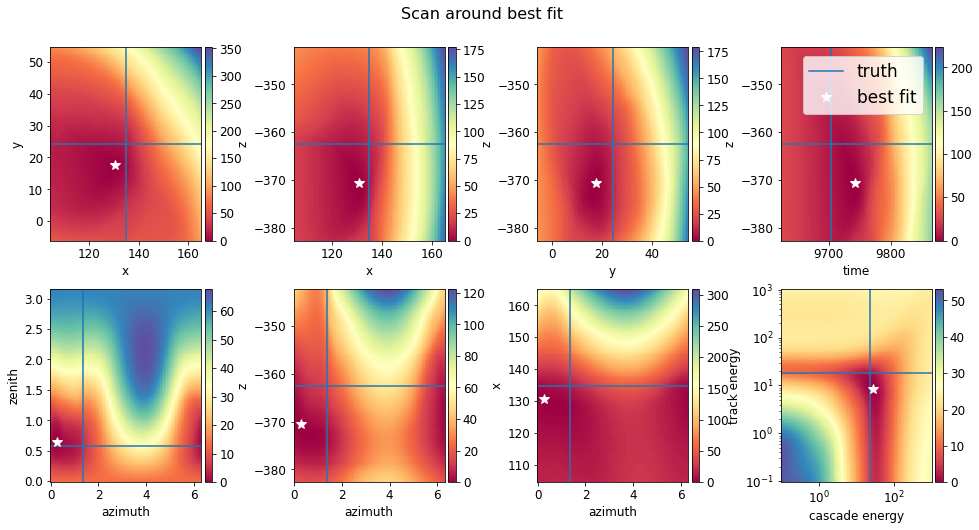

In [23]:
%%time
plot_2d_scan(fit_result["x"])
plt.gcf().suptitle('Scan around best fit', fontsize=16, y=0.95)

### Kill the LLH services

In [24]:
import zmq
def kill_services(addrs, procs):
    for addr, proc in zip(addrs, procs):
        with zmq.Context.instance().socket(zmq.REQ) as ctrl_sock:
            ctrl_sock.connect(addr)
            ctrl_sock.send_string("die")
            proc.join()

In [25]:
kill_services([dc_ctrl_addr, mdom_ctrl_addr, degg_ctrl_addr], [dc_proc, mdom_proc, degg_proc])